In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import math
import matplotlib.pyplot as plt

In [2]:
def display_bgr2rgp(img):
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(rgb_img)
    plt.show()
    
def preprocess(img, factor=2):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = Image.fromarray(img)
    enhancer = ImageEnhance.Sharpness(img).enhance(factor)
    if gray.std() < 30:
        enhancer = ImageEnhance.Contrast(enhancer).enhance(factor)
    return np.array(enhancer)

def cell_in_same_row(c1, c2):
    c1_center = c1[1] + c1[3] / 2
    c2_bottom = c2[1] + c2[3]
    c2_top = c2[1]
    return c2_top < c1_center < c2_bottom

def avg_height_of_center(row):
    centers = [y + h / 2 for x, y, w, h in row]
    return sum(centers) / len(centers)

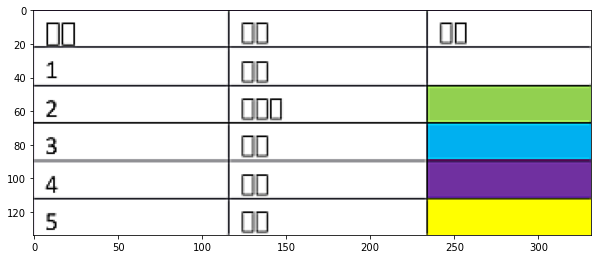

In [108]:
img_path = "images/48868.png"

img = cv.imread(img_path)
img = preprocess(img, 2)

display_bgr2rgp(img)

In [109]:
def binarilize(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (3,3), 0, 0)
    thresh = cv.adaptiveThreshold(~blur,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,5,-2,)
    # remove border noise
    cv.rectangle(thresh, (0,0), thresh.shape[::-1], 0, 3)
    return thresh

def remove_border(thresh, REMOVE_SCALE=3):
    # get vertical and horizontal lines and remove them
    vertical = horizontal = thresh.copy()
    img_height, img_width = horizontal.shape
    
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(img_width / REMOVE_SCALE), 1))
    horizontally_opened = cv.morphologyEx(thresh, cv.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, int(img_height / REMOVE_SCALE)))
    vertically_opened = cv.morphologyEx(thresh, cv.MORPH_OPEN, vertical_kernel)
    both = horizontally_opened + vertically_opened
    both = cv.dilate(both, cv.getStructuringElement(cv.MORPH_RECT, (5,5)))
    
    borderless = thresh - both

    return borderless

def check_combine_column(a, b, MIN_COLUMN_SPACE=12):
    #x2 > x1
    x1, y1, w1, h1 = a
    x2, y2, w2, h2 = b
    
    col_space = x2 - (x1 + w1) + 1
    if col_space < MIN_COLUMN_SPACE:
        new_rect = (x1, min(y1, y2), w2+x2-x1+1, max(y1+h1, y2+h2) - min(y1,y2)+ 1)
        return new_rect
    else:
        return False
    
# def check_combine_row(a, b, MIN_ROW_SPACE=12):
#     #y2 > y1
#     x1, y1, w1, h1 = a
#     x2, y2, w2, h2 = b
    
#     row_space = y2 - (y1 + h1) + 1
#     if row_space < MIN_ROW_SPACE:
#         new_rect = (min(x1,x2), y1, max(x1+w1, x2+w2) - min(x1,x2) + 1, h2+y2-y1+1)
#         return new_rect
#     else:
#         return False
    
def reduce_col(rects, MIN_COLUMN_SPACE=12):
    cursor = len(rects) - 1
    while cursor > 0:
        last = rects[cursor]
        next_last = rects[cursor-1] if rects[cursor-1] else None
        if next_last:
            check = check_combine_column(next_last, last, MIN_COLUMN_SPACE)
            if check != False:
                rects.pop(cursor)
                rects.pop(cursor - 1)
                rects.insert(cursor-1, check)
        cursor -= 1
    return rects

# def reduce_row(rects, MIN_ROW_SPACE=12):
#     cursor = len(rects) - 1
#     while cursor > 0:
#         last = rects[cursor]
#         next_last = rects[cursor-1] if rects[cursor-1] else None
#         if next_last:
#             check = check_combine_row(last, next_last, MIN_ROW_SPACE)
#             if check != False:
#                 rects.pop(cursor)
#                 rects.pop(cursor - 1)
#                 rects.insert(cursor-1, check)
#         cursor -= 1
#     return rects


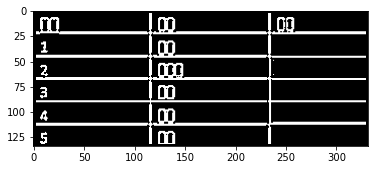

In [110]:
binimg = binarilize(img)
plt.imshow(binimg, cmap='gray')
plt.show()

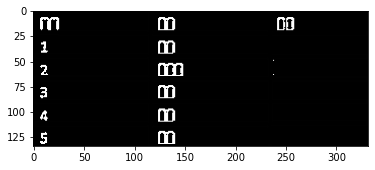

In [111]:
borderless = remove_border(binimg, REMOVE_SCALE=4)
plt.imshow(borderless, cmap='gray')
plt.show()

In [112]:
vertical = horizontal = borderless.copy()
img_height, img_width = horizontal.shape

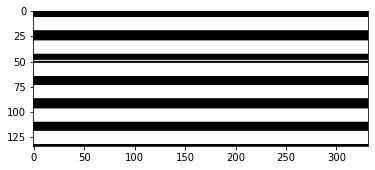

In [113]:
SCALE = 10
horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(img_width / SCALE), 1))
hor_dilate = cv.dilate(horizontal, horizontal_kernel, iterations=20)
_,hor_dilate = cv.threshold(hor_dilate,127,255,cv.THRESH_BINARY)
plt.imshow(hor_dilate, cmap='gray')
plt.show()

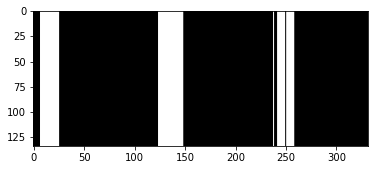

In [114]:
vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1,int(img_width / SCALE)))
ver_dilate = cv.dilate(vertical, vertical_kernel, iterations=20)
_,ver_dilate = cv.threshold(ver_dilate,127,255,cv.THRESH_BINARY)
plt.imshow(ver_dilate, cmap='gray')
plt.show()

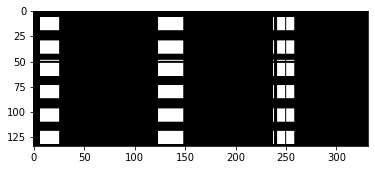

In [115]:
bw_and = cv.bitwise_and(hor_dilate, ver_dilate)
plt.imshow(bw_and, cmap='gray')
plt.show()

In [116]:
contours, hierarchy = cv.findContours(bw_and, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
len(contours)

35

In [117]:
bounding_boxes =  [cv.boundingRect(c) for c in contours]
len(bounding_boxes)

35

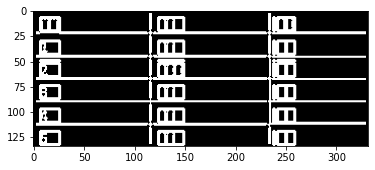

In [118]:
test = binimg.copy()
for box in bounding_boxes:
    cv.rectangle(test, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), 255, 2)
    
plt.imshow(test, cmap='gray')
plt.show()

In [119]:
cells = [c for c in bounding_boxes]

rows = []
while cells:
    first = cells[0]
    rest = cells[1:]
    cells_in_same_row = sorted([c for c in rest if cell_in_same_row(c, first)], key=lambda c: c[0])

    row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
    row_cells = reduce_col(row_cells)
    rows.append(row_cells)
    cells = [c for c in rest if not cell_in_same_row(c, first)]

rows.sort(key=avg_height_of_center)

In [120]:
rows

[[(7, 7, 19, 13), (124, 7, 25, 13), (238, 7, 23, 15)],
 [(7, 30, 19, 13), (124, 30, 25, 13), (238, 30, 23, 15)],
 [(7, 49, 19, 1), (124, 49, 25, 1), (238, 49, 23, 3)],
 [(7, 52, 19, 13), (124, 52, 25, 13), (238, 52, 23, 15)],
 [(7, 74, 19, 13), (124, 74, 25, 13), (238, 74, 23, 15)],
 [(7, 97, 19, 13), (124, 97, 25, 13), (238, 97, 23, 15)],
 [(7, 119, 19, 13), (124, 119, 25, 13), (238, 119, 23, 15)]]

In [121]:
new_rows = []
for row in rows:
    new_row_cell = []
    for cell in row:
        cx, cy, cw, ch = cell
        cell_thresh = borderless[cy:cy+ch, cx:cx+cw]

        ver = hor = cell_thresh.copy()
        ih, iw = hor.shape

#         hor_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(iw/3), 1))
#         ver_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, int(ih/3)))
#         hor_opened = cv.morphologyEx(hor, cv.MORPH_OPEN, hor_kernel)
#         ver_opened = cv.morphologyEx(ver, cv.MORPH_OPEN, ver_kernel)

#         both = hor_opened + ver_opened
#         clean = cell_thresh - both

        kernel = cv.getStructuringElement(cv.MORPH_RECT, (1,int(iw /3)))
        opened = cv.dilate(cell_thresh, kernel)
        contours, hierarchy = cv.findContours(opened, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        bounding_rects = [cv.boundingRect(c) for c in contours]
        MIN_CHAR_HEIGTH = 9
        MIN_CHAR_WIDTH = 5
        char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w >= MIN_CHAR_WIDTH and h >= MIN_CHAR_HEIGTH]
        
        if char_sized_bounding_rects:
            minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
            for x, y, w, h in char_sized_bounding_rects:
                minx = min(minx, x)
                miny = min(miny, y)
                maxx = max(maxx, x + w)
                maxy = max(maxy, y + h)
            x, y, w, h = minx, miny, maxx - minx, maxy - miny
            cropped = (cx+x, cy+y, min(iw, w), min(ih, h))
            new_row_cell.append(cropped)
    if new_row_cell != []:    
        new_rows.append(new_row_cell)
        
new_rows

[[(7, 7, 19, 13), (124, 7, 25, 13), (238, 7, 23, 15)],
 [(7, 30, 19, 13), (124, 30, 25, 13)],
 [(7, 52, 19, 13), (124, 52, 25, 13)],
 [(7, 74, 7, 13), (124, 74, 17, 13)],
 [(7, 97, 19, 13), (124, 97, 25, 13)],
 [(7, 119, 7, 13), (124, 119, 17, 13)]]

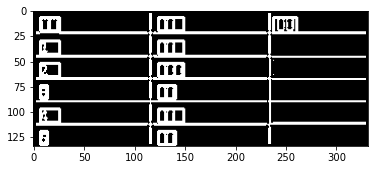

In [122]:
def ravel(lst):
    result = []
    for row in lst:
        for cell in row:
            result.append(cell)

    return result

bnd_rects = ravel(new_rows)
test = binimg.copy()
for box in bnd_rects:
    cv.rectangle(test, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), 255, 2)
    
plt.imshow(test, cmap='gray')
plt.show()